In [7]:
import os
#import sys
dir_parent = os.getcwd() #os.path.abspath(os.path.join(os.getcwd(), os.pardir))
#sys.path.append(dir_parent) # add parent directory to path
import time
import json
import mlflow
import winsound
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils_beeps import beeps
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler # MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from src.utils_general import get_df_parquet
from src.utils_model import get_ls_col
from src.utils_model import plot_pr_curve
from src.utils_model import save_pr_curve
from src.utils_model import save_feature_importance
dir_train = os.path.join(dir_parent, 'data', 'train')
dir_models = os.path.join(dir_parent, 'data', 'models')
dir_images = os.path.join(dir_parent, 'data', 'images')
dir_mlflow = 'file:' + os.sep + os.path.join(dir_parent, 'mlflow')
mlflow.set_tracking_uri(dir_mlflow)

class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model

    def predict(self, context, model_input):
        return self.model.predict_proba(model_input)[:,1]

class RandomForestClassifierFlow():
    def __init__(self, params={}, tags={}):
        self.model = RandomForestClassifier(**params)
        tags['model'] = 'RandomForestClassifier'
        self.tags = tags
        self.params = params

    def mlflow_run(self, df):
        with mlflow.start_run() as run:
            run_id = run.info.run_uuid
            experiment_id = run.info.experiment_id
            # train test split
            train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df[['is_profit']])
            y = train['is_profit'].copy()
            X = train.drop(columns=['is_profit']).copy()
            y_test = test['is_profit'].copy()
            X_test = test.drop(columns=['is_profit']).copy()
            # pipeline
            float_cols = df.select_dtypes(include='float64').columns
            preprocessor = ColumnTransformer([
                ('RobustScaler', RobustScaler(), float_cols),
                #('OneHotEncoder', OneHotEncoder(), cat_cols),
                ]
                ,remainder='passthrough')
            full_pipe = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('model', self.model),])
            # fit
            t_start = time.time()
            full_pipe.fit(X, y)
            t_training = time.time() - t_start
            # predict
            t_start = time.time()
            y_test_pred_proba = full_pipe.predict_proba(X_test)
            t_prediction = time.time() - t_start
            # score
            proba_threshold = 0.75
            metrics = {
                'auroc':roc_auc_score(y_test, y_test_pred_proba[:,1]),
                'precision':precision_score(y_test, (y_test_pred_proba[:,1]>proba_threshold)),
                't_training':t_training,
                't_prediction':t_prediction,
            }
            # pr curve, feature importance
            save_pr_curve(y_test, y_test_pred_proba[:,1])
            save_feature_importance(X_test.columns, full_pipe['model'].feature_importances_)
            # log params, metrics, tags
            mlflow.log_params(self.params)
            mlflow.log_metrics(metrics)
            mlflow.log_artifact(dir_images)
            mlflow.set_tags(self.tags)
            # log Model
            #mlflow.sklearn.log_model(full_pipe, artifact_path='model')
            #wrapped_model = SklearnModelWrapper(full_pipe)
            #mlflow.pyfunc.log_model('model', python_model=wrapped_model)
            return full_pipe

[print(f"'{x}',") for x in os.listdir(dir_train) if x[-8:]=='.parquet'];

'df_train_20201204_1216.parquet',
'df_train_20201204_1219.parquet',
'df_train_20201212_1545.parquet',
'df_train_20201220_1446.parquet',
'df_train_20201226_1503.parquet',
'df_train_20210112_2304.parquet',


# Prep data

In [8]:
# df_train - Import
ls_f = [   
    'df_train_20201204_1216.parquet',
    'df_train_20201204_1219.parquet',
    'df_train_20201212_1545.parquet',
    'df_train_20201220_1446.parquet',
    'df_train_20201226_1503.parquet',
    'df_train_20210112_2304.parquet',
]
df = get_df_parquet(ls_f, dir_train)

# df_train - Remove outliers and non-relevant data 
q = '''
    divergence=='bull_reg'\
    and prev_close>5\
    and abs(sma9_var)<0.02\
    and abs(sma180_var)<0.2\
    and abs(vwap_var)<0.2\
    and abs(spread14_e)<0.02\
    and abs(prev_close_var)<0.5\
    and abs(prev_floor_var)<0.5\
    and abs(prev_ceil_var)<0.5\
    and abs(prev1_candle_score)<0.02\
    and abs(prev2_candle_score)<0.02\
    and abs(prev3_candle_score)<0.02\
    and mins_from_start<300\
    and valley_interval_mins<200\
    and valley_close_score<10\
    and abs(day_open_var)<1.5\
    and abs(open_from_prev_close_var)<0.4\
    and abs(ceil_var)<0.2\
    and abs(floor_var)<0.2\
'''
df = df.query(q)

# df_train - get dates
df = df[df['datetime'].dt.date.astype('str')>'2020-06-28']
inputs_date_start = df['datetime'].dt.date.astype('str').unique().min()
inputs_date_end = df['datetime'].dt.date.astype('str').unique().max()
print(inputs_date_start, inputs_date_end)

# df_train - Remove unwanted columns
ls_col_remove = [
    'sym',
    'datetime',
    'prev_close',
    'divergence',
    'profit',
    ###
    #'valley_interval_mins',
    #'floor_var',
    #'sma9_var',
    #'prev_close_var',
    #'ceil_var',
    #'prev_ceil_var',
]
df = df.drop(columns=ls_col_remove)
ls_col = list(df.drop(columns='is_profit'))

# df-train - Preview
df.info()

2020-06-29 2021-01-08
<class 'pandas.core.frame.DataFrame'>
Int64Index: 241128 entries, 83 to 246
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   is_profit                 241128 non-null  bool   
 1   rsi14                     241128 non-null  float64
 2   sma9_var                  241128 non-null  float64
 3   sma180_var                241128 non-null  float64
 4   vwap_var                  241128 non-null  float64
 5   spread14_e                241128 non-null  float64
 6   volume14_34_var           241128 non-null  float64
 7   prev_close_var            241128 non-null  float64
 8   prev_floor_var            241128 non-null  float64
 9   prev_ceil_var             241128 non-null  float64
 10  prev1_candle_score        241128 non-null  float64
 11  prev2_candle_score        241128 non-null  float64
 12  prev3_candle_score        241128 non-null  float64
 13  mins_from_start         

# Run test

In [9]:
params = {
    'n_jobs': -1,
    'random_state': 42,
}
params = {
    'max_depth': 2048,
    'max_features': 3,
    'min_samples_leaf': 2,
    'min_samples_split': 2,
    'n_estimators': 800,
    ###
    'n_jobs': -1,
    'random_state': 42,
}
params = {
    'criterion': 'entropy',
    'max_depth': 1000,
    'max_features': 'sqrt',
    'min_samples_leaf': 4,
    'min_samples_split': 5,
    'n_estimators': 600,
    ###
    'n_jobs': -1,
    'random_state': 42,
}

tags = {
    'inputs_date_start':inputs_date_start,
    'inputs_date_end':inputs_date_end,
    'df_train files':str(ls_f),
    'comments':''
}
rfcf = RandomForestClassifierFlow(params, tags)
full_pipe = rfcf.mlflow_run(df)

<Figure size 432x288 with 0 Axes>

# Save model

In [ ]:
import pickle
import datetime
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H%M")
tup_model = (q, ls_col, full_pipe)
f = os.path.join(dir_models, f'tup_model_{timestamp}.p')
pickle.dump(tup_model, open(f, 'wb'))
f

# RandomizedSearchCV

In [3]:
import pprint

random_grid = {
    'n_estimators': [800], # Number of trees in random forest
    'max_depth': [2048, None],
    'max_features': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 4, 8],
}

random_grid = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [1000, 2000, 3000, 4000],
    'max_features': ['auto', 'sqrt','log2', None],
    'min_samples_leaf': [4, 6, 8, 12],
    'min_samples_split': [5, 7, 10, 14],
    'n_estimators': [400, 600, 800]
}
pprint.pprint(random_grid)

{'criterion': ['entropy', 'gini'],
 'max_depth': [1000, 2000, 3000, 4000],
 'max_features': ['auto', 'sqrt', 'log2', None],
 'min_samples_leaf': [4, 6, 8, 12],
 'min_samples_split': [5, 7, 10, 14],
 'n_estimators': [400, 600, 800]}


In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

# Use the random grid to search for best hyperparameters
model = RandomForestClassifier()
model_random_cv = RandomizedSearchCV(
    estimator = model,
    param_distributions = random_grid,
    n_iter = 10,
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
    verbose=2,
    random_state=42,
    n_jobs = -1,
    scoring = 'roc_auc'
)
# Run random search
y = df['is_profit'].copy()
X = df.drop(columns=['is_profit']).copy()
model_random_cv.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 76.1min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [1000, 2000, 3000, 4000],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [4, 6, 8, 12],
                                        'min_samples_split': [5, 7, 10, 14],
                                        'n_estimators': [400, 600, 800]},
                   random_state=42, scoring='roc_auc', verbose=2)

In [5]:
# Print results
for tup in sorted(zip(model_random_cv.cv_results_['params'], model_random_cv.cv_results_['mean_test_score']), key = lambda x: x[1], reverse=1):
    pprint.pprint(tup[0])
    print(round(tup[1], 5))
    print()
beeps()

{'criterion': 'entropy',
 'max_depth': 3000,
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'min_samples_split': 14,
 'n_estimators': 600}
0.74938

{'criterion': 'entropy',
 'max_depth': 1000,
 'max_features': 'log2',
 'min_samples_leaf': 8,
 'min_samples_split': 5,
 'n_estimators': 600}
0.74925

{'criterion': 'gini',
 'max_depth': 4000,
 'max_features': 'log2',
 'min_samples_leaf': 6,
 'min_samples_split': 10,
 'n_estimators': 600}
0.74858

{'criterion': 'gini',
 'max_depth': 3000,
 'max_features': 'log2',
 'min_samples_leaf': 12,
 'min_samples_split': 14,
 'n_estimators': 600}
0.74852

{'criterion': 'gini',
 'max_depth': 1000,
 'max_features': 'sqrt',
 'min_samples_leaf': 12,
 'min_samples_split': 10,
 'n_estimators': 800}
0.74847

{'criterion': 'gini',
 'max_depth': 3000,
 'max_features': 'sqrt',
 'min_samples_leaf': 12,
 'min_samples_split': 5,
 'n_estimators': 800}
0.74846

{'criterion': 'gini',
 'max_depth': 2000,
 'max_features': 'sqrt',
 'min_samples_leaf': 12,
 'min_samples

# Correlation

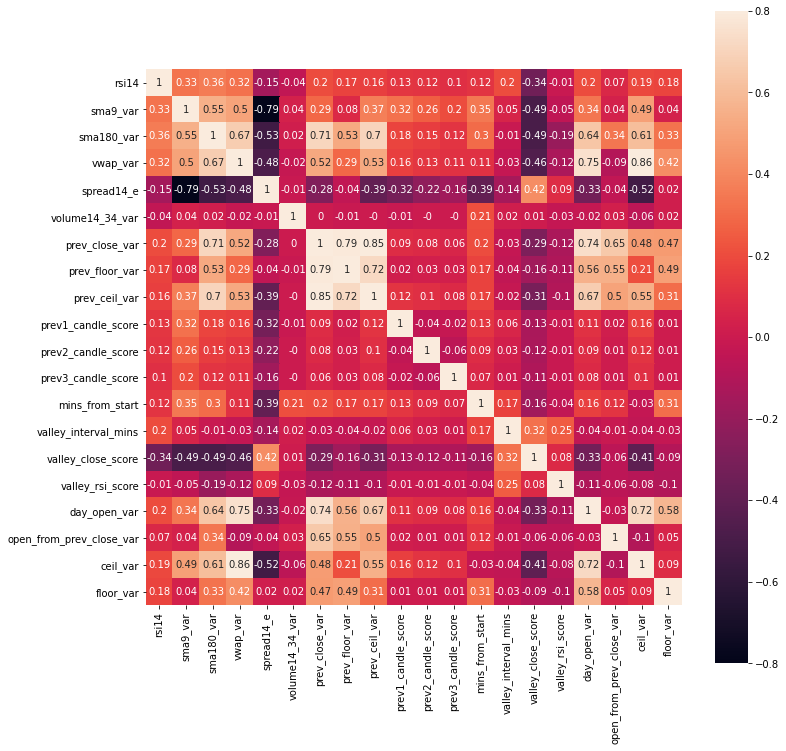

In [9]:
# correlation matrix
df_corr = df.drop(columns=['is_profit']).corr().round(2)
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(df_corr, vmin=-.8, vmax=.8, square=1, annot=True)

# Boxplots

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

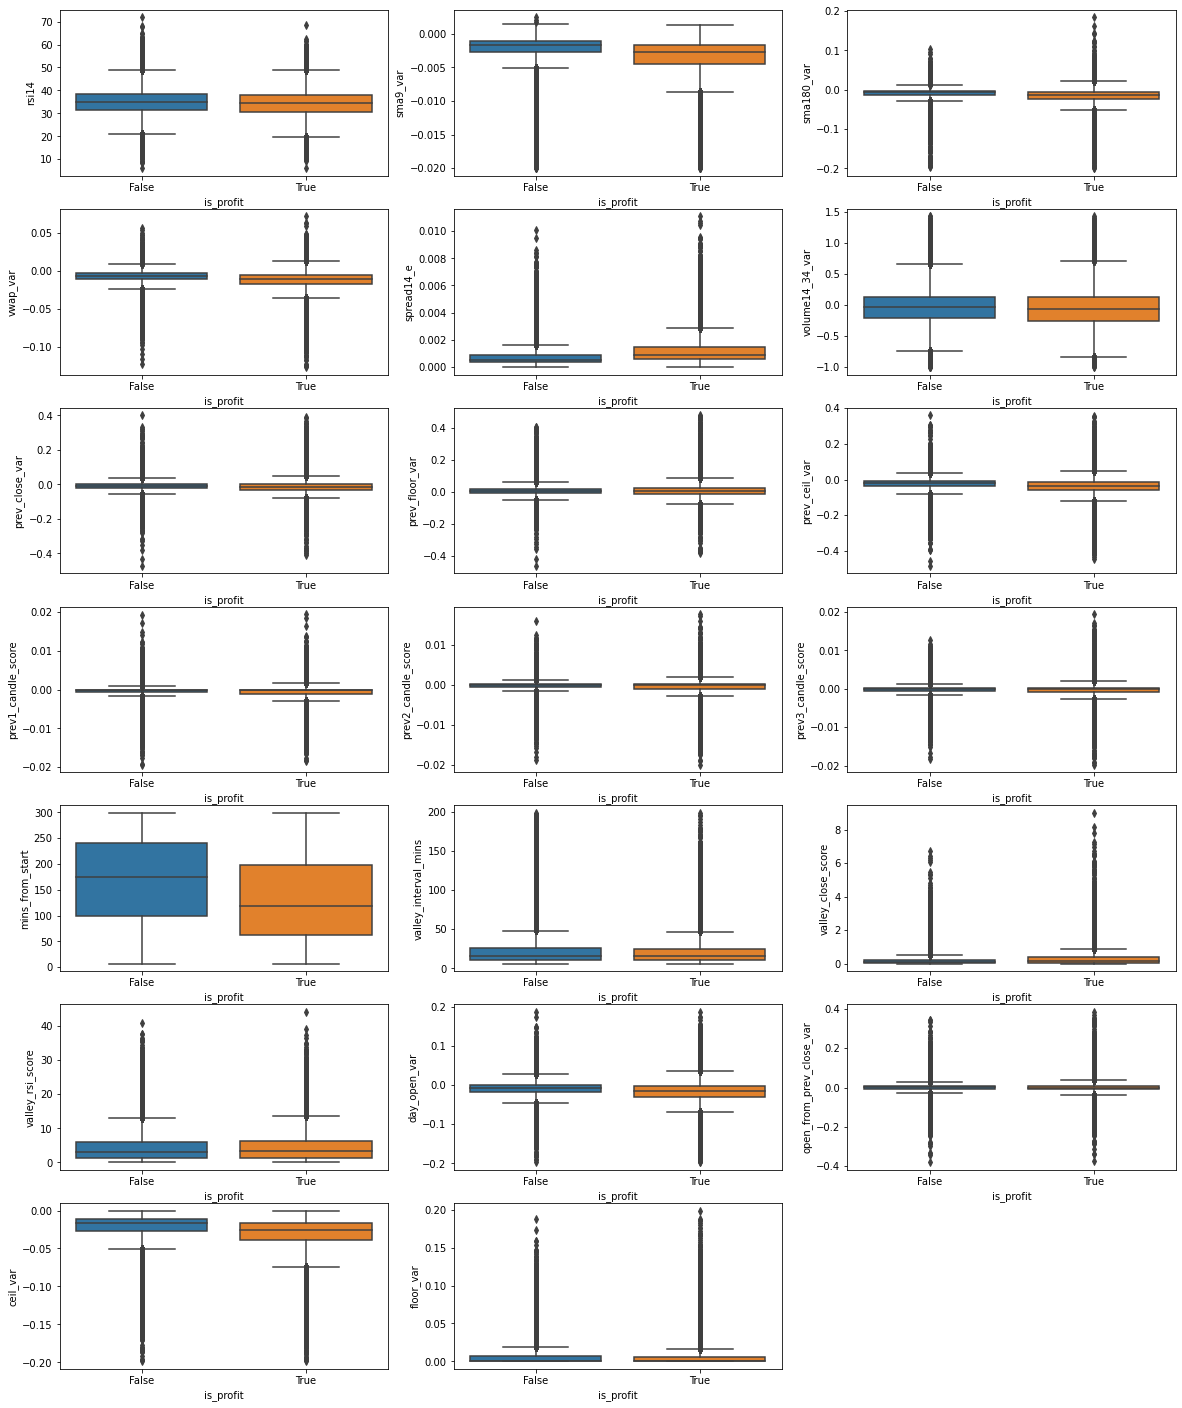

In [10]:
fig = plt.figure(figsize = (20, 25))
for i, col in enumerate(df.drop(columns='is_profit').columns):
    print(i, end=' ')
    plt.subplot(7, 3, i+1)
    sns.boxplot(x='is_profit', y=col, data=df)
plt.show()

# Histograms

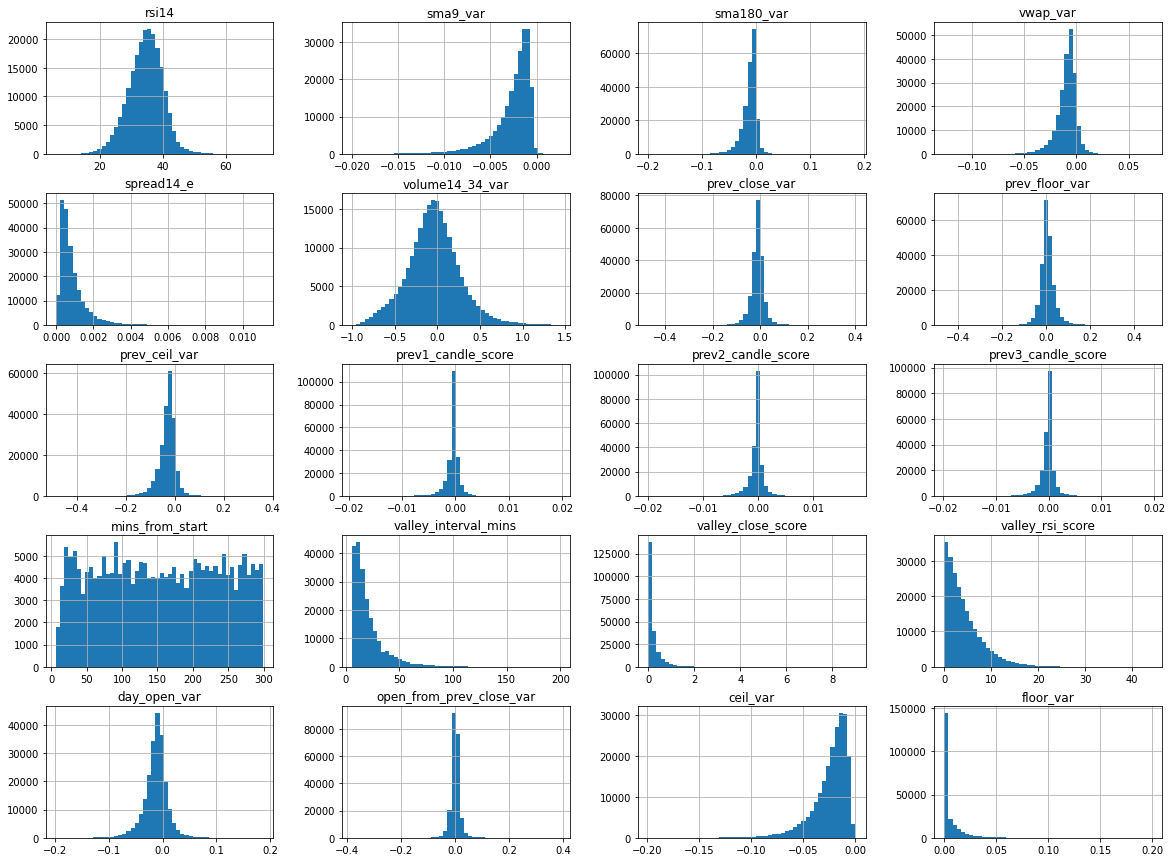

In [39]:
df_e = df.drop(columns='is_profit').copy()
df_e.hist(bins=50, figsize=(20,15))
plt.show()

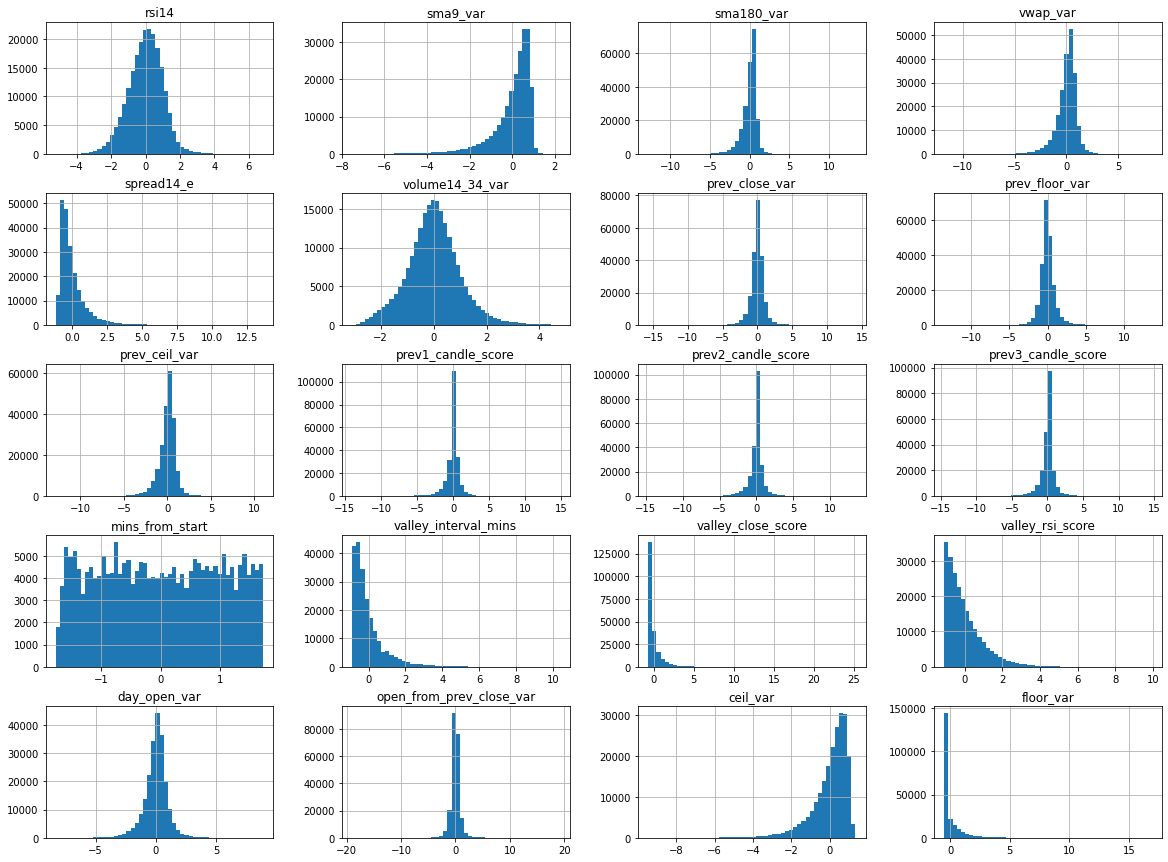

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_e = df.drop(columns='is_profit').copy()
df_e[df_e.columns] = scaler.fit_transform(df_e[df_e.columns])
df_e.hist(bins=50, figsize=(20,15))
plt.show()

# Distplots

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

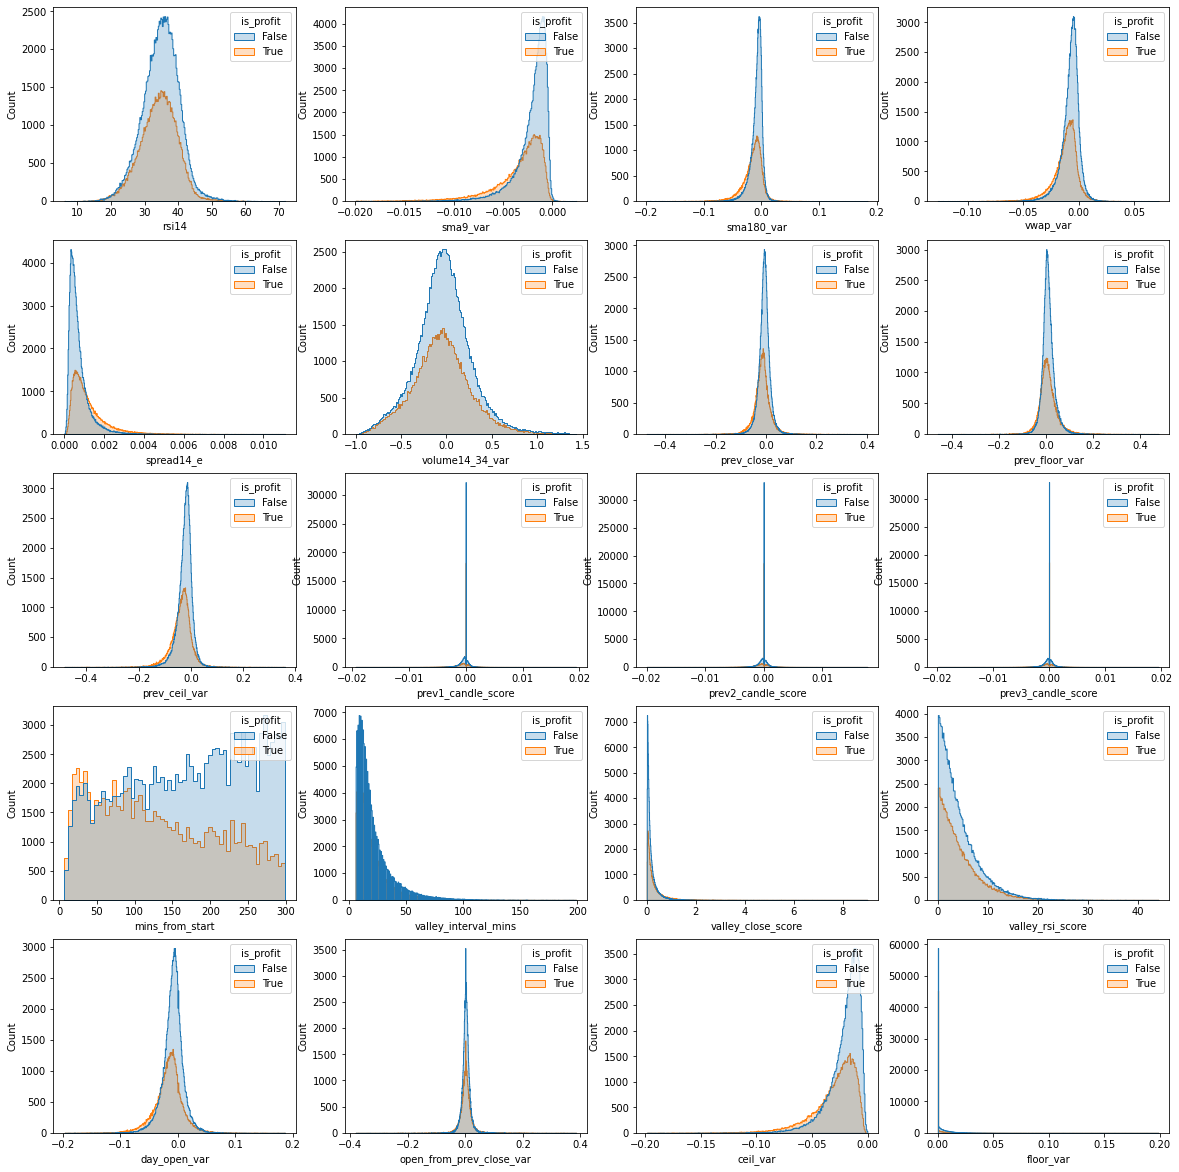

In [51]:
fig = plt.figure(figsize = (20, 25))
for i, col in enumerate(df.drop(columns='is_profit').columns):
    print(i, end=' ')
    plt.subplot(int(len(df.columns)/4)+1, 4, i+1)
    #sns.displot(data=df, x=col, hue='is_profit', kind="kde", fill=True)
    sns.histplot(data=df, x=col, hue='is_profit', element='step')
    #plt.legend(loc='best')
plt.show()

In [19]:
df_s = df.skew(axis=0).reset_index(name='skew')
df_s['normal'] = np.where(df_s['skew'].abs()<2, 1, 0)
df_s

,index,skew,normal
0,is_profit,0.510542,1
1,rsi14,-0.114942,1
2,sma9_var,-2.454097,0
3,sma180_var,-2.114404,0
4,vwap_var,-1.654278,1
5,spread14_e,2.779818,0
6,volume14_34_var,0.290312,1
7,prev_close_var,0.000539,1
8,prev_floor_var,1.296480,1
9,prev_ceil_var,-1.009648,1
